In [1]:
pip install Brian2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 12.9 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#import
from brian2 import *
import math
import plotly.graph_objects as go    # for data visualisation
import plotly.io as pio              # to set shahin plot layout
pio.templates['shahin'] = pio.to_templated(go.Figure().update_layout(margin=dict(t=0,r=0,b=40,l=40))).layout.template
pio.templates.default = 'shahin'
import pandas as pd
from sklearn import datasets
import numpy as np
from numpy import savetxt,loadtxt
%matplotlib inline
#prefs.codegen.target = 'numpy'  # use the Python fallback

In [4]:
################################################################################
# Model parameters
################################################################################
### General parameters
N_e = 4                   # Number of excitatory neurons  :3200 in original 
N_i = 1                    # Number of inhibitory neurons  :800 in original 
N_a = 4                   # Number of astrocytes :3200 in original

## Some metrics parameters needed to establish proper connections
size = 3.75*mmeter           # Length and width of the square lattice
distance = 50*umeter         # Distance between neurons

### Neuron parameters
E_l = -60*mV                 # Leak reversal potential
g_l = 9.99*nS                # Leak conductance
E_e = 0*mV                   # Excitatory synaptic reversal potential
E_i = -80*mV                 # Inhibitory synaptic reversal potential
C_m = 198*pF                 # Membrane capacitance
tau_e = 5*ms                 # Excitatory synaptic time constant
tau_i = 10*ms                # Inhibitory synaptic time constant
tau_r = 5*ms                 # Refractory period
I_ex = 100*pA                # External current
V_th = -50*mV                # Firing threshold
V_r = E_l                    # Reset potential

### Synapse parameters
rho_c = 0.005                # Synaptic vesicle-to-extracellular space volume ratio
Y_T = 500.*mmolar            # Total vesicular neurotransmitter concentration
Omega_c = 40/second          # Neurotransmitter clearance rate
U_0__star = 0.6              # Resting synaptic release probability
Omega_f = 3.33/second        # Synaptic facilitation rate
Omega_d = 2.0/second         # Synaptic depression rate
w_e = 0.05*nS                # Excitatory synaptic conductance
w_i = 1.0*nS                 # Inhibitory synaptic conductance
# --- Presynaptic receptors
O_G = 1.5/umolar/second      # Agonist binding (activating) rate
Omega_G = 0.5/(60*second)    # Agonist release (deactivating) rate

### Astrocyte parameters
# ---  Calcium fluxes
O_P = 0.9*umolar/second      # Maximal Ca^2+ uptake rate by SERCAs
K_P = 0.05*umolar            # Ca2+ affinity of SERCAs
C_T = 2*umolar               # Total cell free Ca^2+ content
rho_A = 0.18                 # ER-to-cytoplasm volume ratio
Omega_C = 6/second           # Maximal rate of Ca^2+ release by IP_3Rs
Omega_L = 0.1/second         # Maximal rate of Ca^2+ leak from the ER
# --- IP_3R kinectics
d_1 = 0.13*umolar            # IP_3 binding affinity
d_2 = 1.05*umolar            # Ca^2+ inactivation dissociation constant
O_2 = 0.2/umolar/second      # IP_3R binding rate for Ca^2+ inhibition
d_3 = 0.9434*umolar          # IP_3 dissociation constant
d_5 = 0.08*umolar            # Ca^2+ activation dissociation constant
# --- IP_3 production
# --- Agonist-dependent IP_3 production
O_beta = 0.5*umolar/second   # Maximal rate of IP_3 production by PLCbeta
O_N = 0.3/umolar/second      # Agonist binding rate
Omega_N = 0.5/second         # Maximal inactivation rate
K_KC = 0.5*umolar            # Ca^2+ affinity of PKC
zeta = 10                    # Maximal reduction of receptor affinity by PKC
# --- Endogenous IP3 production
O_delta = 1.2*umolar/second  # Maximal rate of IP_3 production by PLCdelta
kappa_delta = 1.5*umolar     # Inhibition constant of PLC_delta by IP_3
K_delta = 0.1*umolar         # Ca^2+ affinity of PLCdelta
# --- IP_3 degradation
Omega_5P = 0.05/second       # Maximal rate of IP_3 degradation by IP-5P
K_D = 0.7*umolar             # Ca^2+ affinity of IP3-3K
K_3K = 1.0*umolar            # IP_3 affinity of IP_3-3K
O_3K = 4.5*umolar/second     # Maximal rate of IP_3 degradation by IP_3-3K
# --- IP_3 diffusion
F = 0.09*umolar/second       # GJC IP_3 permeability
I_Theta = 0.3*umolar         # Threshold gradient for IP_3 diffusion
omega_I = 0.05*umolar        # Scaling factor of diffusion
# --- Gliotransmitter release and time course
C_Theta = 0.5*umolar         # Ca^2+ threshold for exocytosis
Omega_A = 0.6/second         # Gliotransmitter recycling rate
U_A = 0.6                    # Gliotransmitter release probability
G_T = 200*mmolar             # Total vesicular gliotransmitter concentration
rho_e = 6.5e-4               # Astrocytic vesicle-to-extracellular volume ratio
Omega_e = 60/second          # Gliotransmitter clearance rate
alpha = 0.0                  # Gliotransmission nature


In [5]:
################################################################################
# Define HF stimulus
################################################################################
stimulus = TimedArray([1.0, 1.2, 1.0, 1.0], dt=2*second)

################################################################################
# Simulation time (based on the stimulus)
################################################################################
duration = 8*second          # Total simulation time

################################################################################
# Model definition
################################################################################
### Neurons
# INCLUDE BEGIN
neuron_eqs = '''
# ELLIPSIS BEGIN
dv/dt = (g_l*(E_l-v) + g_e*(E_e-v) + g_i*(E_i-v) + I_ex*stimulus(t))/C_m : volt (unless refractory)
dg_e/dt = -g_e/tau_e : siemens  # post-synaptic excitatory conductance
dg_i/dt = -g_i/tau_i : siemens  # post-synaptic inhibitory conductance
# ELLIPSIS END
# Neuron position in space
x : meter (constant)
y : meter (constant)
'''
neurons = NeuronGroup(N_e + N_i, model=neuron_eqs,
                      threshold='v>V_th', reset='v=V_r',
                      refractory='tau_r', method='euler')
exc_neurons = neurons[:N_e]
inh_neurons = neurons[N_e:]
# Arrange excitatory neurons in a grid
N_rows = int(sqrt(N_e))
N_cols = N_e/N_rows
grid_dist = (size / N_cols)
exc_neurons.x = '(i / N_rows)*grid_dist - N_rows/2.0*grid_dist'
exc_neurons.y = '(i % N_rows)*grid_dist - N_cols/2.0*grid_dist'
# INCLUDE END
# Random initial membrane potential values and conductances
neurons.v = 'E_l + rand()*(V_th-E_l)'
neurons.g_e = 'rand()*w_e'
neurons.g_i = 'rand()*w_i'

### Synapses
# INCLUDE BEGIN
synapses_eqs = '''
# ELLIPSIS BEGIN
# Neurotransmitter
dY_S/dt = -Omega_c * Y_S                                    : mmolar (clock-driven)
# Fraction of activated presynaptic receptors
dGamma_S/dt = O_G * G_A * (1 - Gamma_S) - Omega_G * Gamma_S : 1 (clock-driven)
# Usage of releasable neurotransmitter per single action potential:
du_S/dt = -Omega_f * u_S                                    : 1 (event-driven)
# Fraction of synaptic neurotransmitter resources available for release:
dx_S/dt = Omega_d *(1 - x_S)                                : 1 (event-driven)
U_0                                                         : 1
# released synaptic neurotransmitter resources:
r_S                                                         : 1
# gliotransmitter concentration in the extracellular space:
G_A                                                         : mmolar
# ELLIPSIS END
# which astrocyte covers this synapse ?
astrocyte_index : integer (constant)
'''
# ELLIPSIS BEGIN
synapses_action = '''
U_0 = (1 - Gamma_S) * U_0__star + alpha * Gamma_S
u_S += U_0 * (1 - u_S)
r_S = u_S * x_S
x_S -= r_S
Y_S += rho_c * Y_T * r_S
'''
# ELLIPSIS END
exc_syn = Synapses(exc_neurons, neurons, model=synapses_eqs,
                   on_pre=synapses_action+'g_e_post += w_e*r_S',method='linear')
# INCLUDE END
exc_syn.connect(True, p=0.05)
exc_syn.x_S = 1.0
inh_syn = Synapses(inh_neurons, neurons, model=synapses_eqs,
                   on_pre=synapses_action+'g_i_post += w_i*r_S',
                   method='linear')
inh_syn.connect(True, p=0.2)
inh_syn.x_S = 1.0
# Connect excitatory synapses to an astrocyte depending on the position of the
# post-synaptic neuron
# INCLUDE BEGIN
N_rows_a = int(sqrt(N_a))
N_cols_a = N_a/N_rows_a
grid_dist = size / N_rows_a
exc_syn.astrocyte_index = ('abs(int(x_post/grid_dist) + '
                           'N_cols_a*int(y_post/grid_dist))')
# INCLUDE END
### Astrocytes
# The astrocyte emits gliotransmitter when its Ca^2+ concentration crosses
# a threshold
# INCLUDE BEGIN
astro_eqs = '''
# ELLIPSIS BEGIN
# Fraction of activated astrocyte receptors:
dGamma_A/dt = O_N * Y_S * (1 - clip(Gamma_A,0,1)) -
              Omega_N*(1 + zeta * C/(C + K_KC)) * clip(Gamma_A,0,1) : 1
# Intracellular IP_3
dI/dt = J_beta + J_delta - J_3K - J_5P + J_coupling              : mmolar
J_beta = O_beta * Gamma_A                                        : mmolar/second
J_delta = O_delta/(1 + I/kappa_delta) * C**2/(C**2 + K_delta**2) : mmolar/second
J_3K = O_3K * C**4/(C**4 + K_D**4) * I/(I + K_3K)                : mmolar/second
J_5P = Omega_5P*I                                                : mmolar/second
# Diffusion between astrocytes:
J_coupling                                                       : mmolar/second
# Ca^2+-induced Ca^2+ release:
dC/dt = J_r + J_l - J_p                                   : mmolar
dh/dt = (h_inf - h)/tau_h                                 : 1
J_r = (Omega_C * m_inf**3 * h**3) * (C_T - (1 + rho_A)*C) : mmolar/second
J_l = Omega_L * (C_T - (1 + rho_A)*C)                     : mmolar/second
J_p = O_P * C**2/(C**2 + K_P**2)                          : mmolar/second
m_inf = I/(I + d_1) * C/(C + d_5)                         : 1
h_inf = Q_2/(Q_2 + C)                                     : 1
tau_h = 1/(O_2 * (Q_2 + C))                               : second
Q_2 = d_2 * (I + d_1)/(I + d_3)                           : mmolar
# Fraction of gliotransmitter resources available for release:
dx_A/dt = Omega_A * (1 - x_A) : 1
# gliotransmitter concentration in the extracellular space:
dG_A/dt = -Omega_e*G_A        : mmolar
# Neurotransmitter concentration in the extracellular space:
Y_S                           : mmolar
# ELLIPSIS END
# The astrocyte position in space
x : meter (constant)
y : meter (constant)
'''
# ELLIPSIS BEGIN
glio_release = '''
G_A += rho_e * G_T * U_A * x_A
x_A -= U_A *  x_A
'''
astrocytes = NeuronGroup(N_a, astro_eqs,
                         # The following formulation makes sure that a "spike" is
                         # only triggered at the first threshold crossing
                         threshold='C>C_Theta',
                         refractory='C>C_Theta',
                         # The gliotransmitter release happens when the threshold
                         # is crossed, in Brian terms it can therefore be
                         # considered a "reset"
                         reset=glio_release,
                         method='rk4',
                         dt=1e-2*second)
# ELLIPSIS END
# Arrange astrocytes in a grid
astrocytes.x = '(i / N_rows_a)*grid_dist - N_rows_a/2.0*grid_dist'
astrocytes.y = '(i % N_rows_a)*grid_dist - N_cols_a/2.0*grid_dist'
# INCLUDE END
# Add random initialization
astrocytes.C = 0.01*umolar
astrocytes.h = 0.9
astrocytes.I = 0.01*umolar
astrocytes.x_A = 1.0

# INCLUDE BEGIN
ecs_astro_to_syn = Synapses(astrocytes, exc_syn,
                            'G_A_post = G_A_pre : mmolar (summed)')
ecs_astro_to_syn.connect('i == astrocyte_index_post')
ecs_syn_to_astro = Synapses(exc_syn, astrocytes,
                            'Y_S_post = Y_S_pre/N_incoming : mmolar (summed)')
ecs_syn_to_astro.connect('astrocyte_index_pre == j')
# INCLUDE END
# Diffusion between astrocytes
astro_to_astro_eqs = '''
delta_I = I_post - I_pre            : mmolar
J_coupling_post = -(1 + tanh((abs(delta_I) - I_Theta)/omega_I))*
                  sign(delta_I)*F/2 : mmolar/second (summed)
'''
astro_to_astro = Synapses(astrocytes, astrocytes,
                          model=astro_to_astro_eqs)
# Connect to all astrocytes less than 75um away
# (about 4 connections per astrocyte)
# INCLUDE BEGIN
astro_to_astro.connect('i != j and '
                       'sqrt((x_pre-x_post)**2 +'
                       '     (y_pre-y_post)**2) < 75*um')
# INCLUDE END

In [6]:
################################################################################
# Monitors
################################################################################
# Note that we could use a single monitor for all neurons instead, but this
# way plotting is a bit easier in the end
exc_mon = SpikeMonitor(exc_neurons)
inh_mon = SpikeMonitor(inh_neurons)
ast_mon = SpikeMonitor(astrocytes)

exe_stat=StateMonitor(exc_neurons,['x','y','v'],record=True)
exc_syn_stat=StateMonitor(exc_syn,['astrocyte_index','G_A','r_S','Y_S','x_S','Gamma_S','u_S','g_e'],record=True)
ast_stat=StateMonitor(astrocytes,['x','y','G_A','Gamma_A','C','h','I','x_A','Y_S'],record=True)
astro_to_astro_stat=StateMonitor(astro_to_astro,['J_coupling'],record=True)

################################################################################
# Simulation run
################################################################################
run(duration)

In [7]:
print(exc_syn.i)
print(exc_syn.j)

<synapses.i: array([0, 2], dtype=int32)>
<synapses.j: array([3, 0], dtype=int32)>


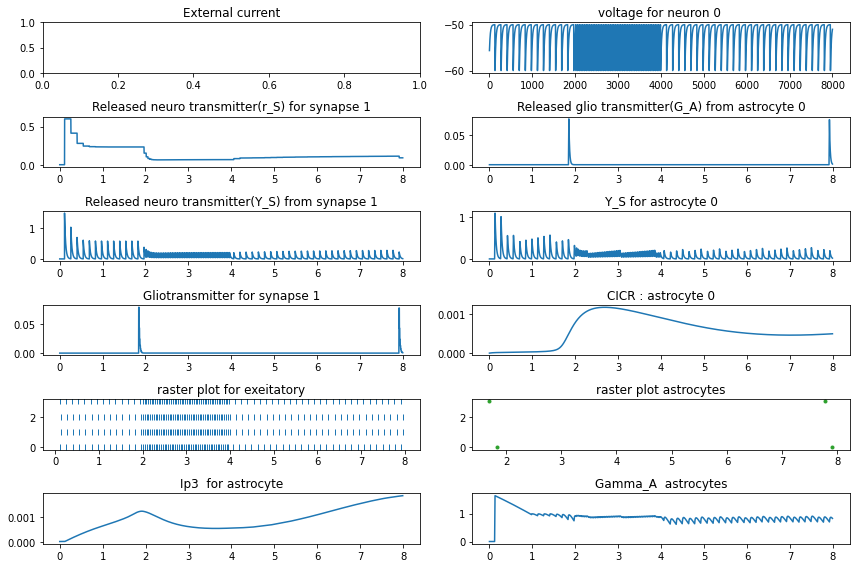

In [8]:
################################################################################
# Plot of Spiking activity
################################################################################
fig, ax = plt.subplots(6, 2, figsize=(12, 8))
#time_range = np.linspace(0, duration, 5000)
#ax[0,0].plot(time_range, I)
ax[0, 0].set_title('External current')

ax[0,1].plot(exe_stat.t/ms, exe_stat.v[2]/mV)
ax[0, 1].set_title('voltage for neuron 0 ')

ax[1,0].plot(exc_syn_stat.t/second, exc_syn_stat.r_S[0,:])
ax[1, 0].set_title('Released neuro transmitter(r_S) for synapse 1')
ax[1,1].plot(ast_stat.t/second, ast_stat.G_A[0,:])
ax[1, 1].set_title('Released glio transmitter(G_A) from astrocyte 0')

ax[2,0].plot(exc_syn_stat.t/second, exc_syn_stat.Y_S[0,:])
ax[2, 0].set_title('Released neuro transmitter(Y_S) from synapse 1')
ax[2,1].plot(ast_stat.t/second, ast_stat.Y_S[0,:])
ax[2, 1].set_title('Y_S for astrocyte 0')

ax[3,0].plot(exc_syn_stat.t/second, exc_syn_stat.G_A[0,:])
ax[3, 0].set_title('Gliotransmitter for synapse 1')
ax[3,1].plot(ast_stat.t/second, ast_stat.C[0,:])
ax[3, 1].set_title('CICR : astrocyte 0')

ax[4,0].plot(exc_mon.t/second, exc_mon.i, '|' , color='C0')
ax[4, 0].set_title('raster plot for exeitatory')
ax[4,1].plot(ast_mon.t/second, ast_mon.i,'.k' , color='C2')
ax[4, 1].set_title('raster plot astrocytes')

ax[5,0].plot(ast_stat.t/second, ast_stat.I[0,:])
ax[5, 0].set_title('Ip3  for astrocyte')
ax[5,1].plot(ast_stat.t/second, ast_stat.Gamma_A[0,:])
ax[5, 1].set_title('Gamma_A  astrocytes')

fig.tight_layout()